In [1]:
# using Pkg
# Pkg.generate("model1")

In [2]:
# using Pkg
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataDrivenDiffEq")
# Pkg.add("LinearAlgebra")
# Pkg.add("DiffEqSensitivity")
# Pkg.add("Optim")
# Pkg.add("DiffEqFlux")
# Pkg.add("Flux")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("GLM")
# Pkg.add("StatsModels")
# Pkg.add("CSV")
# Pkg.add("Interpolations")
# Pkg.add("JLD2")
# Pkg.add("Suppressor")
# Pkg.add("Distributed")
# Pkg.add("ParallelDataTransfer")
# Pkg.add("LaTeXStrings")
# Pkg.add("Statistics")
# Pkg.add("StatsBase")

In [3]:
println(@__DIR__)
using Pkg
# Pkg.update()
Pkg.activate(string(@__DIR__, "/0/Project.toml"))
Pkg.status()
# Pkg.instantiate()

/home/ziyu/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload


 Activating new environment at `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/0/Project.toml`


Status `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/0/Project.toml`
  (empty environment)


In [4]:
# cd(@__DIR__)
# using Pkg; Pkg.activate("."); Pkg.instantiate()
using OrdinaryDiffEq, DifferentialEquations
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using DataFrames, GLM, StatsModels
using CSV
using Interpolations
using JLD2
using Suppressor
using Distributed
using ParallelDataTransfer
using LaTeXStrings, Statistics
using StatsBase
gr()

Plots.GRBackend()

# Loading and cleaning data and parameters

(Transfer learning for faster training) We find that the neural network parameters from conducting the same experiment on data from China are general enough to be used as an initialisation point of the neural network for other countries. 

In [5]:
# country = "Botswana"
country = "United_States"

paras = CSV.read(string(@__DIR__, "/model1_initialisation/parametersrelu.csv"), 
    normalizenames = true, 
    DataFrame)

nnp = Array(paras[!,country])


232-element Array{Float64,1}:
 -0.4423288152682153
 -0.12279195881851783
 -0.3049511998234965
 -0.11113284671742184
 -0.471099163191946
 -0.5544088163458708
 -0.24976782573540718
  0.4416532032802888
 -0.15656781489893798
 -0.09874294712640953
 -0.19308050274358984
 -0.2831031992919947
 -0.025812991529291802
  ⋮
 -0.18074229468378167
 -0.1281120804864246
  0.06968247510550324
  0.1606807931740668
 -0.38399706873153844
 -0.4256534477937857
  0.418302079875063
 -0.13322231382665148
 -0.004701963671961055
 -0.06868846566277304
  0.035786737031872566
 -0.03800406229908861

In [6]:
function getCleandataFrame(country)
    df_year=df[!,"Year"][2:end]
    df1=df[!,string(country,"_yt")]  #GDP
    df2=df[!,string(country,"_kt")] #capital per capita
    df3=df[!,string(country,"_srate")][2:end] # savig rate
    df6= df[!,string(country,"_et")] #population
    df4= df[!,string(country,"_nt")][2:end] #population
    df8=df6[1:end-1] .-df6[2:end]#de
    df6=df6[2:end]
    df5=df2[1:end-1] .-df2[2:end] #dk
    df2=df2[2:end]
    df7= df1[1:end-1] .-df1[2:end] # dydt
    df1=df1[2:end]
    newdf= DataFrame(Year=df_year,yt=df1, k=df2, srate=df3,nt=df4,dkdt=df5,dydt=df7,dedt=df8,et=df6)
    newdf=newdf[completecases(newdf), :]
    return newdf, df8, df5, df7
end

getCleandataFrame (generic function with 1 method)

In [7]:
df = CSV.read(string(@__DIR__, "/compileddf.csv"),
    normalizenames = true, 
    DataFrame)

newdf, df8, df5, df7=getCleandataFrame(country)
years_available=size(newdf)[1]


st = interpolate(newdf[!,"srate"], BSpline(Quadratic(Free(OnCell()))))
nt = interpolate(newdf[!,"nt"], BSpline(Quadratic(Free(OnCell()))))

kdata= newdf[!,"k"]
ydata=newdf[!,"yt"]
edata=newdf[!,"et"]
kic= newdf[!,"k"][1]
yic=newdf[!,"yt"][1]
eic=newdf[!,"et"][1]

newdf

,Year,yt,k,srate,nt,dkdt,dydt,dedt
,Int64,Float64?,Float64,Float64?,Float64?,Float64,Float64?,Float64?
1,1970,0.01503,0.0632449,0.215383,0.0117182,-0.0013165,0.000149,-1.25331
2,1971,0.015304,0.0651057,0.215138,0.0127236,-0.00186078,-0.000274,0.131049
3,1972,0.015944,0.067476,0.220847,0.0107627,-0.00237027,-0.00064,-0.768438
4,1973,0.016689,0.0706719,0.236784,0.00959046,-0.00319589,-0.000745,-0.76194
5,1974,0.016491,0.0743356,0.225658,0.00917847,-0.0036637,0.000198,1.00765
6,1975,0.016284,0.0764952,0.209196,0.00990863,-0.00215967,0.000207,1.10071
7,1976,0.016975,0.0777832,0.215083,0.00954749,-0.00128791,-0.000691,-0.755391
8,1977,0.017567,0.0809296,0.221992,0.0101085,-0.00314647,-0.000592,-0.374869
9,1978,0.018373,0.0851758,0.234459,0.0106521,-0.00424616,-0.000806,-0.440521


# Optimising the neural network

In [8]:
ann = FastChain(FastDense(1, 12, tanh),FastDense(12, 12, tanh),
                    FastDense(12, 4))

function solownneqn1(du,u,p,t)
    sₜ = st(t) #savings rate
    nₜ = nt(t)

    k = u[1]
    y=u[2]
    e=u[3]
    α,δ,gᵦ,gₐ= ann([t],p) 
    # using a neural network to represent the parameters α,δ,gᵦ,gₐ
    # p within the neural network are pretrained parameters of the nn (nnp)
    # ie the weights and biases
    # the neural network takes in one parameter, time and 
    # essentially finds the best α,δ,gᵦ,gₐ values for that time step
#     println("parameters: ", α, " ", δ, " ", gᵦ, " ", gₐ)
    du[1] = sₜ*y-(δ+nₜ+gᵦ)*k # rate of change of kt
    du[2] = y*(gᵦ+α*du[1]/k) # rate of change of yt
    du[3] = e*(-gₐ+du[2]/y)
    return du
end


function predicts(θ)
        Array(solve(prob_solownneqn,TRBDF2(),p=θ, abstol=1e-4, reltol=1e-4, saveat = nntsteps))
    end

    losses=[]

    
function loss(θ)
    pred = predicts(θ)
    kloss=sum(abs,(pred[1,:].-kdata))./ sum(pred[1,:].+ kdata)
    yloss=sum(abs, (pred[2,:].-ydata))./sum(pred[2,:].+ydata)
    eloss=sum(abs,(pred[3,:].-edata))./sum(pred[3,:].+edata)
    return ((kloss+eloss+yloss)), pred
end
          
callback(θ,l,pred) = begin
        push!(losses, l)
        false
end

nntspan = (1.0e0,years_available*1.0) ## the year is hard coded, to be changed later
nndatasize = years_available
nntsteps = range(nntspan[1], nntspan[2], length=nndatasize)
u0 = Float32[kic,yic,eic] ## kt initial
prob_solownneqn = ODEProblem(solownneqn1, u0, nntspan, nnp)
pred = solve(prob_solownneqn, TRBDF2(),p=nnp, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

retcode: Success
Interpolation: 1st order linear
t: 39-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 28.0
 29.0
 30.0
 31.0
 32.0
 33.0
 34.0
 35.0
 36.0
 37.0
 38.0
 39.0
u: 39-element Array{Array{Float32,1},1}:
 [0.06324493, 0.01503, 21.111252]
 [0.064254835, 0.015462034, 22.090324]
 [0.063723564, 0.015623218, 22.096512]
 [0.062176883, 0.015859434, 21.784998]
 [0.06005245, 0.016238531, 21.477556]
 [0.05768977, 0.016716978, 21.23395]
 [0.055764463, 0.01721749, 21.03238]
 [0.054637235, 0.017694497, 20.842443]
 [0.054390326, 0.018125646, 20.649555]
 [0.05495432, 0.018512094, 20.45488]
 [0.05598784, 0.01887133, 20.271738]
 [0.057609532, 0.019207103, 20.09894]
 [0.05968618, 0.019532096, 19.94216]
 ⋮
 [0.112645194, 0.025795624, 19.408113]
 [0.117779076, 0.026321359, 19.42721]
 [0.12310394, 0.0268602, 19.448631]
 [0.1285749, 0.027412614, 19.472334]
 [0.1340972, 0.027979467, 19.498526]
 [0.1395401, 0.028561927, 19.527676]
 [0.144

In [9]:
res1= DiffEqFlux.sciml_train(loss, nnp, ADAM(0.0001),cb=callback, maxiters=100)

while ((mean(losses[end-100:end-50])>=(1.001*mean(losses[end-49:end]))) || std(losses[end-49:end]) >=0.001) && length(losses) <3000

res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)

catch e
    print("Problematics")
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
end
res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
catch e
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
    print("Problematics")
end

end


loss: 0.0822: 100%|█████████████████████████████████████| Time: 0:00:13
loss: 0.059: 100%|██████████████████████████████████████| Time: 0:00:26
loss: 0.0577: 100%|█████████████████████████████████████| Time: 0:00:12
loss: 0.0483: 100%|█████████████████████████████████████| Time: 0:00:20
loss: 0.0466: 100%|█████████████████████████████████████| Time: 0:00:12
loss: 0.0419: 100%|█████████████████████████████████████| Time: 0:00:22
loss: 0.0417: 100%|█████████████████████████████████████| Time: 0:00:09
loss: 0.0407: 100%|█████████████████████████████████████| Time: 0:00:19
loss: 0.0403: 100%|█████████████████████████████████████| Time: 0:00:09
loss: 0.0409: 100%|█████████████████████████████████████| Time: 0:00:23
loss: 0.0401: 100%|█████████████████████████████████████| Time: 0:00:09
loss: 0.04: 100%|███████████████████████████████████████| Time: 0:00:23
loss: 0.0398: 100%|█████████████████████████████████████| Time: 0:00:09
loss: 0.0403: 100%|█████████████████████████████████████| Time: 

In [10]:
# printing the values of the parameters at each time step (generated by the neural network)

for i in 1:39
    println(ann(i, res1.minimizer))
end

[0.10537653739334321; -0.07565627001924445; 0.06416784288733315; -0.022062126593277408]
[0.0682373434837523; -0.03607300349577791; 0.019983017913578052; 0.0007926715089638728]
[0.002670916430609546; -0.023155543992698716; 0.010859002493549583; 0.022688332949877522]
[-0.03509656686768567; -0.015972179001925678; 0.01563855012283366; 0.03601910516337995]
[-0.051272394506442026; -0.010772160557009518; 0.021334495740509246; 0.04086804158293426]
[-0.0564572969543268; -0.007123223931467297; 0.02421687685561863; 0.04060676335602146]
[-0.05685283285828316; -0.004826799732296536; 0.024583252781582077; 0.03799722739006298]
[-0.05545930963370169; -0.0036204456942005164; 0.023601119010646585; 0.034663308971668284]
[-0.05360459976415591; -0.003220682970813446; 0.022204215597512372; 0.031414667528206576]
[-0.05182210329825357; -0.003367491956680846; 0.020913992516204266; 0.02858872861408738]
[-0.050288997043022726; -0.003847775032004966; 0.01994145124560809; 0.026277216502851343]
[-0.0490335128325986

In [11]:
#generating the data
pred = solve(prob_solownneqn, TRBDF2(),p=res1.minimizer, abstol=1e-4, reltol=1e-4, saveat = nntsteps)
    kmse = Flux.mse(pred[1,:],kdata)
    ymse = Flux.mse(pred[2,:],ydata)
    emse = Flux.mse(pred[3,:],edata)
println(kmse,"",ymse,"",emse)

3.515191815624572e-52.4519735796207987e-70.45433722263069937


# Plotting a graph

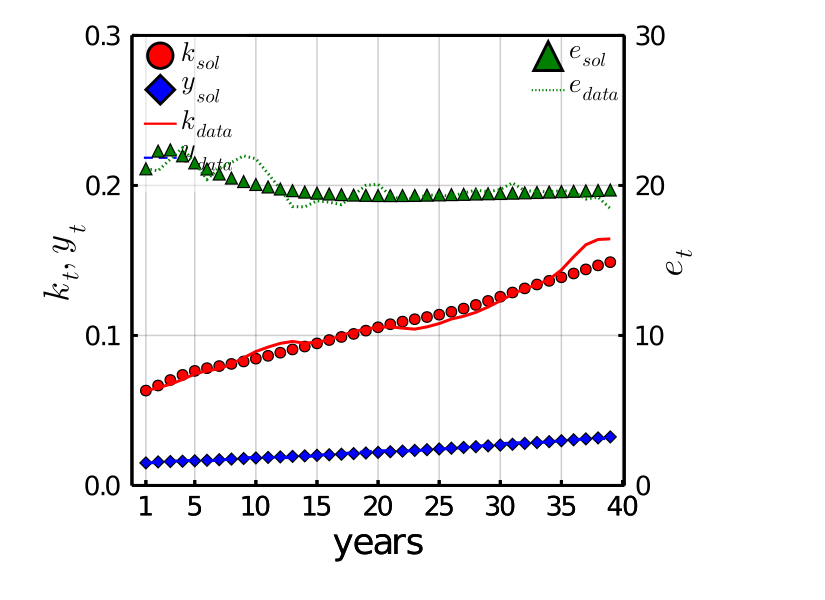

In [12]:
 function plot_graph(nnpred,country,nntstepsfull,kdata,ydata,edata)
    upscale = 0.5 #1 #8x upscaling in resolution
    fntsm = Plots.font("sans-serif", pointsize=round(12.0*upscale))
    fntlg = Plots.font("sans-serif", pointsize=round(16.0*upscale))
    default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
    default(size=(550*upscale,400*upscale)) #Plot canvas size
    default(dpi=300)
    
#     fctime = collect(Int(floor(size(nntstepsfull,1)*0.8))+1:1:size(nntstepsfull,1)) 
# #             println(fctime)
#             println(nntstepsfull)
    plotkyenn12ic= Plots.scatter(xaxis=nntstepsfull,nnpred[1:2,:]',
        label=[L"k_{sol}" L"y_{sol}"],color=[:red :blue],legend=(0.102,0.955),
        markershape=[:circle :diamond],markersize=4*upscale,
        ylabel=L"k_t,y_t",right_margin = 15Plots.mm)
            
    plot!(plotkyenn12ic,[kdata,ydata],label=[L"k_{data}" L"y_{data}"],linestyle=[:solid :dash],
        color=[:red :blue],ylim=(0,1.5.*round(maximum(kdata);sigdigits=1)),foreground_color_legend = nothing)

#     scatter!(plotkyenn12ic,nntstepsfull,nnpred[1:2,:]',
#         color=[:red :blue],markershape=[:circle :diamond], markersize=4,label=nothing)

    pr = twinx()
    
#     scatter!(pr,nntstepsfull,nnpred[3,:],
#         color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4, label=nothing)

    Plots.scatter!(pr,nntstepsfull,nnpred[3,:],
        label=L"e_{sol}",color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4*upscale,
        ylabel=L"e_t",right_margin = 15Plots.mm,
        foreground_color_legend = nothing,background_color_legend = nothing)
            
    plot!(pr,edata,label=L"e_{data}",color=:green,ylim=(0,1.5.*round(maximum(edata);sigdigits=1)),
                linestyle=:dot)
    
 xpts = collect(0:5:5*ceil(length(nntstepsfull)/5))
#     if xpts[end] != length(nntsteps)
#         push!(xpts,length(nntsteps))
        xpts[1]=1
#     end
    
   plot(plotkyenn12ic,xlabel = "years",xticks=xpts,box=:on,linewidth=2*upscale)
#     display(StatsPlots.plot(pl,xlabel = "Days post 21 March 2020",xticks=0:10:110,tickfont=12,
#         guidefont = 16,legendfontsize=12,legend=(0.1,0.92),
#         dpi=300,box=:on,linewidth=2*upscale))

#     savefig(string(country,"model4_190621"))
end

plot_graph(pred,country,nntsteps,kdata,ydata,edata)

In [13]:
USA_k_pred = convert(Array{Float64},pred[1,:])
USA_y_pred = convert(Array{Float64},pred[2,:])
USA_e_pred = convert(Array{Float64},pred[3,:])
kdata = identity.(kdata)
ydata = identity.(ydata)
edata = identity.(edata)

#checking the implementation of MSE
# println("(USA Mean Squared Errors) kt: ", Flux.mse(USA_k_pred, kdata), 
#     " yt: ", Flux.mse(USA_y_pred, ydata), 
#     " et: ", Flux.mse(USA_e_pred, edata))
println("(USA Mean Squared Errors) kt: ", (sqL2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(USA_e_pred, edata)/length(edata)))
println("(USA Root Mean Squared Errors) kt: ", (L2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(USA_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(USA Mean Absolute Errors) kt: ", Flux.mae(USA_k_pred, kdata), 
#     " yt: ", Flux.mae(USA_y_pred, ydata), 
#     " et: ", Flux.mae(USA_e_pred, edata))
println("(USA Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},USA_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},USA_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},USA_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(USA R2 Correlation Coefficient) yt: ", r2(ols_y_USA),
#     " et: ", r2(ols_e_USA))
# println("(USA R2 Correlation Coefficient) yt: ", r2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", r2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA R2 Correlation Coefficient) kt: ", r2_impl(kdata, USA_k_pred), 
    " yt: ", r2_impl(ydata, USA_y_pred), 
    " et: ", r2_impl(edata, USA_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(USA Adjusted R2) yt: ", adjr2(ols_y_USA),
#     " et: ", adjr2(ols_e_USA))
# println("(USA Adjusted R2) yt: ", Ar2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA),2),
#     " et: ", Ar2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 232 parameters 
# (should divide by 3 because 232 parameters are used for 3 equations?)
println("(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 232), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 232), 
    " et: ", Ar2_impl(edata, USA_e_pred, 232))

println("(USA Mean Percentage Error) kt: ", mean((kdata.- USA_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- USA_y_pred)./ydata)*100,
    " et: ", mean((edata.- USA_e_pred)./edata)*100)

println("(USA Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- USA_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- USA_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- USA_e_pred)./edata))*100)

println("(USA Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- USA_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- USA_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- USA_e_pred)./edata)))*100)

println("(USA Mean Bias Error) kt: ", mean(kdata.- USA_k_pred),
    " yt: ", mean(ydata.- USA_y_pred),
    " et: ", mean(edata.- USA_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(USA Loglikelihood) yt: ", loglikelihood(ols_y_USA),
#     " et: ", loglikelihood(ols_e_USA))
# println("(USA Loglikelihood) yt: ", loglikelihood_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", loglikelihood_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA Loglikelihood) kt: ", loglikelihood_calc(kdata, USA_k_pred),
    " yt: ", loglikelihood_calc(ydata, USA_y_pred),
    " et: ", loglikelihood_calc(edata, USA_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(USA Aikaike Information Criterion) yt: ", aic(ols_y_USA),
#     " et: ", aic(ols_e_USA))
# println("(USA Aikaike Information Criterion) yt: ", aic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance
# for AIC, did not include the variance as a parameter (because it isnt being estimated by the nn)
println("(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 232),
    " yt: ", aic_calc(ydata, USA_y_pred, 232),
    " et: ", aic_calc(edata, USA_e_pred, 232))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(USA Corrected AIC) yt: ", aicc(ols_y_USA),
#     " et: ", aicc(ols_e_USA))
# println("(USA Corrected AIC) yt: ", aicc_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aicc_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 232),
    " yt: ", aicc_calc(ydata, USA_y_pred, 232),
    " et: ", aicc_calc(edata, USA_e_pred, 232))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(USA Corrected BIC) yt: ", bic(ols_y_USA),
#     " et: ", bic(ols_e_USA))
# println("(USA Corrected BIC) yt: ", bic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", bic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 232),
    " yt: ", bic_calc(ydata, USA_y_pred, 232),
    " et: ", bic_calc(edata, USA_e_pred, 232))


println("(param-adj)(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 206), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 206), 
    " et: ", Ar2_impl(edata, USA_e_pred, 193))
println("(param-adj)(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 206),
    " yt: ", aic_calc(ydata, USA_y_pred, 206),
    " et: ", aic_calc(edata, USA_e_pred, 193))
println("(param-adj)(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 206),
    " yt: ", aicc_calc(ydata, USA_y_pred, 206),
    " et: ", aicc_calc(edata, USA_e_pred, 193))
println("(param-adj)(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 206),
    " yt: ", bic_calc(ydata, USA_y_pred, 206),
    " et: ", bic_calc(edata, USA_e_pred, 193))

(USA Mean Squared Errors) kt: 3.515191815624572e-5 yt: 2.451973579620798e-7 et: 0.45433722263069937
(USA Root Mean Squared Errors) kt: 0.0009493846611229462 yt: 7.929130937635872e-5 et: 0.10793364802111591
(USA Mean Absolute Errors) kt: 0.004075581430997898 yt: 0.00036076603073340177 et: 0.4793532970479018
(USA R2 Correlation Coefficient) kt: 0.9506986638637717 yt: 0.9902757897324854 et: 0.5806766834210046
(USA Adjusted R2) kt: 1.0097069988247496 yt: 1.001914611348008 et: 1.0825610675129629
(USA Mean Percentage Error) kt: 0.3476730335431236 yt: 0.2236660376478171 et: -0.07961830682189411
(USA Mean Absolute Percentage Error) kt: 3.5168433666212597 yt: 1.629884763510369 et: 2.375920106188046
(USA Mean Arctangent Absolute Percentage Error) kt: 3.5120207241231176 yt: 1.6292713427365466 et: 2.373890237483519
(USA Mean Bias Error) kt: 0.0009403417584316726 yt: 6.394379928784493e-5 et: 0.004222471172500701
(USA Loglikelihood) kt: 144.65010893184092 yt: 241.47484416052455 et: -39.9547490719274

In [14]:
kdata = identity.(kdata[2:end-1].-kdata[1:end-2])
USA_k_pred = USA_k_pred[2:end-1].-USA_k_pred[1:end-2]
USA_y_pred = USA_y_pred[2:end-1].-USA_y_pred[1:end-2]
ydata = identity.(ydata[2:end-1].-ydata[1:end-2])
USA_e_pred = USA_e_pred[2:end-1].-USA_e_pred[1:end-2]
edata = identity.(edata[2:end-1].-edata[1:end-2])



#checking the implementation of MSE
# println("(USA Mean Squared Errors) kt: ", Flux.mse(USA_k_pred, kdata), 
#     " yt: ", Flux.mse(USA_y_pred, ydata), 
#     " et: ", Flux.mse(USA_e_pred, edata))
println("(USA Mean Squared Errors) kt: ", (sqL2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(USA_e_pred, edata)/length(edata)))
println("(USA Root Mean Squared Errors) kt: ", (L2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(USA_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(USA Mean Absolute Errors) kt: ", Flux.mae(USA_k_pred, kdata), 
#     " yt: ", Flux.mae(USA_y_pred, ydata), 
#     " et: ", Flux.mae(USA_e_pred, edata))
println("(USA Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},USA_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},USA_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},USA_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(USA R2 Correlation Coefficient) yt: ", r2(ols_y_USA),
#     " et: ", r2(ols_e_USA))
# println("(USA R2 Correlation Coefficient) yt: ", r2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", r2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA R2 Correlation Coefficient) kt: ", r2_impl(kdata, USA_k_pred), 
    " yt: ", r2_impl(ydata, USA_y_pred), 
    " et: ", r2_impl(edata, USA_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(USA Adjusted R2) yt: ", adjr2(ols_y_USA),
#     " et: ", adjr2(ols_e_USA))
# println("(USA Adjusted R2) yt: ", Ar2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA),2),
#     " et: ", Ar2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 232 parameters 
# (should divide by 3 because 232 parameters are used for 3 equations?)
println("(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 232), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 232), 
    " et: ", Ar2_impl(edata, USA_e_pred, 232))

println("(USA Mean Percentage Error) kt: ", mean((kdata.- USA_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- USA_y_pred)./ydata)*100,
    " et: ", mean((edata.- USA_e_pred)./edata)*100)

println("(USA Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- USA_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- USA_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- USA_e_pred)./edata))*100)

println("(USA Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- USA_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- USA_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- USA_e_pred)./edata)))*100)

println("(USA Mean Bias Error) kt: ", mean(kdata.- USA_k_pred),
    " yt: ", mean(ydata.- USA_y_pred),
    " et: ", mean(edata.- USA_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(USA Loglikelihood) yt: ", loglikelihood(ols_y_USA),
#     " et: ", loglikelihood(ols_e_USA))
# println("(USA Loglikelihood) yt: ", loglikelihood_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", loglikelihood_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA Loglikelihood) kt: ", loglikelihood_calc(kdata, USA_k_pred),
    " yt: ", loglikelihood_calc(ydata, USA_y_pred),
    " et: ", loglikelihood_calc(edata, USA_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(USA Aikaike Information Criterion) yt: ", aic(ols_y_USA),
#     " et: ", aic(ols_e_USA))
# println("(USA Aikaike Information Criterion) yt: ", aic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance
# for AIC, did not include the variance as a parameter (because it isnt being estimated by the nn)
println("(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 232),
    " yt: ", aic_calc(ydata, USA_y_pred, 232),
    " et: ", aic_calc(edata, USA_e_pred, 232))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(USA Corrected AIC) yt: ", aicc(ols_y_USA),
#     " et: ", aicc(ols_e_USA))
# println("(USA Corrected AIC) yt: ", aicc_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aicc_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 232),
    " yt: ", aicc_calc(ydata, USA_y_pred, 232),
    " et: ", aicc_calc(edata, USA_e_pred, 232))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(USA Corrected BIC) yt: ", bic(ols_y_USA),
#     " et: ", bic(ols_e_USA))
# println("(USA Corrected BIC) yt: ", bic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", bic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 232),
    " yt: ", bic_calc(ydata, USA_y_pred, 232),
    " et: ", bic_calc(edata, USA_e_pred, 232))


println("(param-adj)(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 206), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 206), 
    " et: ", Ar2_impl(edata, USA_e_pred, 193))
println("(param-adj)(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 206),
    " yt: ", aic_calc(ydata, USA_y_pred, 206),
    " et: ", aic_calc(edata, USA_e_pred, 193))
println("(param-adj)(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 206),
    " yt: ", aicc_calc(ydata, USA_y_pred, 206),
    " et: ", aicc_calc(edata, USA_e_pred, 193))
println("(param-adj)(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 206),
    " yt: ", bic_calc(ydata, USA_y_pred, 206),
    " et: ", bic_calc(edata, USA_e_pred, 193))

(USA Mean Squared Errors) kt: 3.904110232421014e-6 yt: 1.4494205923545785e-7 et: 0.3165180697779755
(USA Root Mean Squared Errors) kt: 0.00032483302290274536 yt: 6.258876059093735e-5 et: 0.09249076941204333
(USA Mean Absolute Errors) kt: 0.0014257520480562926 yt: 0.00030976816274668693 et: 0.4222105640482477
(USA R2 Correlation Coefficient) kt: 0.06119877037814936 yt: -0.03183971690097831 et: -0.13690686259724383
(USA Adjusted R2) kt: 1.173317150084034 yt: 1.1904934861971037 et: 1.2098904977102605
(USA Mean Percentage Error) kt: 12.223390800845669 yt: 57.83730720288743 et: 110.24872299019258
(USA Mean Absolute Percentage Error) kt: 77.80048798367683 yt: 100.89538484346856 et: 132.27388021066952
(USA Mean Arctangent Absolute Percentage Error) kt: 45.933242163360944 yt: 53.678314640960366 et: 78.5450244482017
(USA Mean Bias Error) kt: 0.0004670218922125965 yt: -9.256572124120272e-6 et: -0.012077383474187138
(USA Loglikelihood) kt: 177.8886663713238 yt: 238.8175119398998 et: -31.218789217